<a href="https://colab.research.google.com/github/comojin1994/Deep_Learning_Study/blob/master/3step_lecture/Improve_Overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
tf.__version__

TensorFlow 2.x selected.


'2.1.0'

### Hyperparameter

In [0]:
EPOCHS = 100

### Layers

In [0]:
class ConvLNReluBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(ConvLNReluBlock, self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', use_bias=False)
        self.ln = tf.keras.layers.LayerNormalization()
    
    def call(self, x, training=False, mask=None):
        x = self.conv(x)
        x = self.ln(x) # training여부가 상관 없음
        return tf.nn.relu(x)

In [0]:
def conv(filters, kernel_size, padding, activation):
    return tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, activation=activation,
                                  kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01))
    
def dense(units, activation):
    return tf.keras.layers.Dense(units, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(0.01))

### Load Data

In [0]:
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255., x_test / 255.

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32).prefetch(1024)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32).prefetch(1024)

170500096/170498071 [==============================] - 6s 0us/step


### L2 Regularization & He initializer

### Model 1

In [0]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1_1 = conv(16, (3, 3), padding='same', activation='relu')
        self.conv1_2 = conv(16, (3, 3), padding='same', activation='relu')
        self.pool1 = tf.keras.layers.MaxPool2D((2, 2))

        self.conv2_1 = conv(32, (3, 3), padding='same', activation='relu')
        self.conv2_2 = conv(32, (3, 3), padding='same', activation='relu')
        self.pool2 = tf.keras.layers.MaxPool2D((2, 2))

        self.conv3_1 = conv(64, (3, 3), padding='same', activation='relu')
        self.conv3_2 = conv(64, (3, 3), padding='same', activation='relu')

        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = dense(1024, activation='relu')
        self.dense2 = dense(10, activation='softmax')

    def call(self, x, training=False, mask=None):
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        x = self.pool1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.pool2(x)
        
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)

### Training

In [0]:
model = MyModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss_object, metrics=metrics, )

In [0]:
history = model.fit(
      train_ds,
      epochs=EPOCHS,
      validation_data=test_ds,
)

Train for 1563 steps, validate for 313 steps
Epoch 1/100
1563/1563 [==============================] - 10s 6ms/step - loss: 2.0629 - accuracy: 0.4264 - val_loss: 1.9734 - val_accuracy: 0.4422
Epoch 2/100
1563/1563 [==============================] - 10s 6ms/step - loss: 1.9028 - accuracy: 0.4497 - val_loss: 1.8493 - val_accuracy: 0.4518
Epoch 3/100
1563/1563 [==============================] - 10s 6ms/step - loss: 1.8221 - accuracy: 0.4654 - val_loss: 1.7835 - val_accuracy: 0.4745
Epoch 4/100
1563/1563 [==============================] - 10s 6ms/step - loss: 1.7751 - accuracy: 0.4778 - val_loss: 1.7766 - val_accuracy: 0.4765
Epoch 5/100
1563/1563 [==============================] - 10s 6ms/step - loss: 1.7327 - accuracy: 0.4931 - val_loss: 1.6830 - val_accuracy: 0.5117
Epoch 6/100
1563/1563 [==============================] - 10s 6ms/step - loss: 1.6996 - accuracy: 0.5090 - val_loss: 1.7405 - val_accuracy: 0.4829
Epoch 7/100
1563/1563 [==============================] - 10s 6ms/step - loss: 1

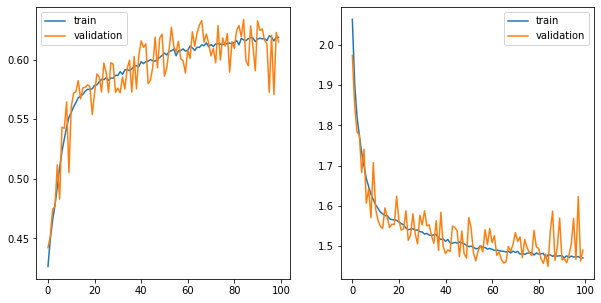

In [0]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation'])

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()

### LayerNormalization & L2 Regularization

### Model 2

In [0]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1_1 = ConvLNReluBlock(16, (3, 3))
        self.conv1_2 = ConvLNReluBlock(16, (3, 3))
        self.pool1 = tf.keras.layers.MaxPool2D((2, 2))

        self.conv2_1 = ConvLNReluBlock(32, (3, 3))
        self.conv2_2 = ConvLNReluBlock(32, (3, 3))
        self.pool2 = tf.keras.layers.MaxPool2D((2, 2))

        self.conv3_1 = ConvLNReluBlock(64, (3, 3))
        self.conv3_2 = ConvLNReluBlock(64, (3, 3))

        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = dense(1024, activation='relu')
        self.dense2 = dense(10, activation='softmax')

    def call(self, x, training=False, mask=None):
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        x = self.pool1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.pool2(x)
        
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        
        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)

### Training

In [0]:
model = MyModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss_object, metrics=metrics, )

In [0]:
history = model.fit(
      train_ds,
      epochs=EPOCHS,
      validation_data=test_ds,
)

Train for 1563 steps, validate for 313 steps
Epoch 1/100
1563/1563 [==============================] - 26s 17ms/step - loss: 2.1718 - accuracy: 0.4186 - val_loss: 1.3546 - val_accuracy: 0.5584
Epoch 2/100
1563/1563 [==============================] - 19s 12ms/step - loss: 1.2645 - accuracy: 0.5977 - val_loss: 1.2019 - val_accuracy: 0.6335
Epoch 3/100
1563/1563 [==============================] - 19s 12ms/step - loss: 1.0812 - accuracy: 0.6641 - val_loss: 1.0409 - val_accuracy: 0.6836
Epoch 4/100
1563/1563 [==============================] - 19s 12ms/step - loss: 0.9856 - accuracy: 0.6978 - val_loss: 1.0000 - val_accuracy: 0.6931
Epoch 5/100
1563/1563 [==============================] - 19s 12ms/step - loss: 0.9206 - accuracy: 0.7199 - val_loss: 0.9327 - val_accuracy: 0.7179
Epoch 6/100
1563/1563 [==============================] - 19s 12ms/step - loss: 0.8679 - accuracy: 0.7367 - val_loss: 0.9038 - val_accuracy: 0.7284
Epoch 7/100
1563/1563 [==============================] - 19s 12ms/step - 

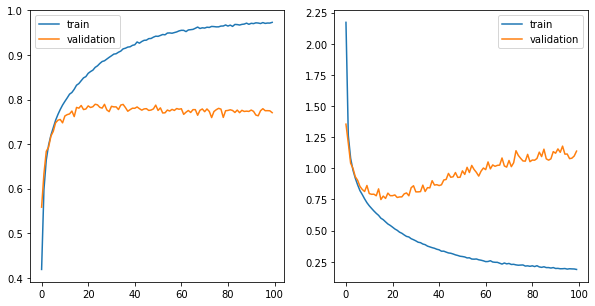

In [0]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation'])

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()